---

# Import Libraries

In this section we import the libraries that will be required to process the data.

The first library is **Pandas**.  
Pandas is an open source, BSD-licensed library, providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [1]:
# Import Pandas and Numpy to provide DataFrame support
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

In [2]:
# Use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

font = {'size'   : 12}
mpl.rc('font', **font)

In [3]:
# Use Folium to display the Maps for Visualisation
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium import plugins

# Module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 


In [5]:
import yaml

with open("./capstone_data/config.yaml", "r") as f:
    cfg = yaml.load(f)
 
search_params = {
    'client_id': cfg['client_id'],
    'client_secret': cfg['client_secret'],
    'intent': 'browse',
    'limit': 50,
    'v': cfg['version']
}

In [7]:
# All the SciKit Learn Libraries Required
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

def cross_validate(model, n_splits = 10):
    
    k_fold = KFold(n_splits = n_splits)
    scores = [model.fit(X[train], y[train]).score(X[test], y[test]) for train, test in k_fold.split(X)]
    
    scores = np.percentile(scores, [40, 50, 60])
    return scores




---

# Import and process the Chicago Crime DataSet
This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago in the last year, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified.

| Column Name   | Type          | Description                                            | 
| :------------ | :------------ | :----------------------------------------------------- | 
| CASE#         | Plain Text    | The Chicago Police Department RD Number (Records Division Number), which is unique to the incident. | 
| DATE OF OCCURRENCE | Date & Time   | Date when the incident occurred. this is sometimes a best estimate. |
| BLOCK	        | Plain Text    | The partially redacted address where the incident occurred, placing it on the same block as the actual address. |
| IUCR	        | Plain Text    | The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e. |
| PRIMARY DESCRIPTION   | Plain Text    | The primary description of the IUCR code. |
| SECONDARY DESCRIPTION	| Plain Text    | The secondary description of the IUCR code, a subcategory of the primary description. |
| LOCATION DESCRIPTION | Plain Text | Description of the location where the incident occurred. |
| ARREST        | Plain Text    | Indicates whether an arrest was made. |
| DOMESTIC      | Plain Text    | Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act. |
| BEAT          | Plain Text    | Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74. |
| WARD	        | Number        | The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76. |
| FBI CD        | Plain Text    | Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html. |
| X COORDINATE	| Plain Text    | The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block. |
| Y COORDINATE	| Plain Text    | The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block. |
| LATITUDE	    | Number        | The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block. |
| LONGITUDE	    | Number        | The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block. |
| LOCATION	    | Location      | The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block. |
	




### Import the 2018 DataSet

The full dataset, 2001 to 2018 contains over 6.7M rows. This makes processing the dataset difficult and time consuming. Only the 2018 data, 187222 records, will be used. In addition, the following clean-up steps are required:
1. Not all of the columns are required. The following columns are removed:
    1. IUCR
    1. ARREST
    1. DOMESTIC
    1. BEAT
    1. WARD
    1. FBI CD
    1. X COORDINATE
    1. Y COORDINATE
    1. LOCATION

In [31]:
# These are the columns that we want to keep.
# Columns not listed here won't be imported, speeding things up.
crime_keep_columns = ['CASE#',
                      'DATE  OF OCCURRENCE',
                      'BLOCK', 
                      ' PRIMARY DESCRIPTION',
                      'WARD',
                      'LATITUDE',
                      'LONGITUDE']

# Download csv
# !wget -O crimes.csv https://data.cityofchicago.org/api/views/x2n5-8w5q/rows.csv?accessType=DOWNLOAD

# Read from local
df = pd.read_csv('./capstone_data/crimes.csv',
                 usecols=crime_keep_columns)

Looking at the Shape of df we can see that only 12 columns have been imported instead of all 22.

In [32]:
df.shape

(264272, 7)

Let's have a quick look at the Head of the imported data

In [34]:
df.head()

,CASE#,DATE OF OCCURRENCE,BLOCK,PRIMARY DESCRIPTION,WARD,LATITUDE,LONGITUDE
0,JB241987,04/28/2018 10:05:00 PM,009XX N LONG AVE,NARCOTICS,37.0,41.897895,-87.760744
1,JB241350,04/28/2018 08:00:00 AM,008XX E 53RD ST,CRIMINAL DAMAGE,5.0,41.798635,-87.604823
2,JB245397,04/28/2018 09:00:00 AM,062XX S MICHIGAN AVE,THEFT,20.0,41.780946,-87.621995
3,JB241444,04/28/2018 12:15:00 PM,046XX N ELSTON AVE,THEFT,39.0,41.965404,-87.736202
4,JB241667,04/28/2018 04:28:00 PM,022XX S KENNETH AVE,ARSON,22.0,41.850673,-87.735597


In [35]:
df.tail()

,CASE#,DATE OF OCCURRENCE,BLOCK,PRIMARY DESCRIPTION,WARD,LATITUDE,LONGITUDE
264267,JA525920,11/26/2017 02:02:00 PM,081XX S ASHLAND AVE,THEFT,21.0,41.746260,-87.663332
264268,JA475906,10/18/2017 01:31:00 PM,048XX N SHERIDAN RD,ASSAULT,46.0,41.969326,-87.654826
264269,JA534571,12/03/2017 03:18:00 AM,002XX W 38TH PL,BATTERY,3.0,41.824547,-87.633096
264270,JA492228,10/30/2017 04:00:00 PM,072XX S SOUTH SHORE DR,THEFT,7.0,41.764728,-87.561272
264271,JA536019,12/02/2017 08:00:00 PM,083XX S INDIANA AVE,CRIMINAL DAMAGE,6.0,41.742865,-87.619547


---
### Clean up the data and prepare

The sample data file was downloaded in the middle of September. So half of September of 2017 was missing and half of September 2018 was not yet populated. To simply resolve this the raw data was altered to move the September 2017 dates to September 2018. 

Now that the data has been imported it needs to be cleaned.
1. Move September 2017 dates to September 2018
1. Clean up the column names:
    1. Strip leading & trailing whitespace
    1. Replace multiple spaces with a single space
    1. Remove # characters
    1. Replace spaces with _
    2. Convert to lowercase
1. Change the date of occurance field to a date / time object
1. Add new columns for:
    1. Hour
    1. Day
    1. Month
    1. Year
    1. etc.
1. Split Block into zip_code and street
1. Verify that all rows have valid data

In [36]:
# Strip leading & trailing whitespace
df.columns = df.columns.str.strip()

# Replace multiple spaces with a single space
df.columns = df.columns.str.replace('\s{2,}', ' ')

# Replace # with blank
df.columns = df.columns.str.replace('#', '')

# Replace spaces with _
df.columns = df.columns.str.replace(' ', '_')

# Convert to lowercase
df.columns = df.columns.str.lower()

# Move September 2017 dates to September 2018
df.date_of_occurrence.replace(to_replace="(09/\\d+)/2017", value=r"\1/2018", regex=True, inplace=True)

In [37]:
df.dtypes

case                    object
date_of_occurrence      object
block                   object
primary_description     object
ward                   float64
latitude               float64
longitude              float64
dtype: object

Change the date of occurance field to a date / time object

In [38]:
df['date_of_occurrence'] =  pd.to_datetime(df['date_of_occurrence'], format='%m/%d/%Y %I:%M:%S %p')

Add new columns for the hour, day, month and year of the crime:
1. Hour
1. Day Name
1. Day of week (Tuesday is the first day)
1. Month Name
1. Month Number
1. Year
1. Year and Month

In [39]:
df['hour'] = df['date_of_occurrence'].dt.hour
df['day_name'] = df['date_of_occurrence'].dt.day_name()
df['day'] = df['date_of_occurrence'].dt.dayofweek + 1
df['month_name'] = df['date_of_occurrence'].dt.month_name()
df['month'] = df['date_of_occurrence'].dt.month
df['year'] = df['date_of_occurrence'].dt.year
df['year_month'] = df['date_of_occurrence'].dt.to_period('M')

Split Block into zip_code and street

In [40]:
df['zip'] = df.block.str.split(' ').str[0]
df['street'] = df.block.str.split(' ').str[1:].apply(', '.join)

Verify that all rows have valid data

In [41]:
df.isna().sum()

case                      0
date_of_occurrence        0
block                     0
primary_description       0
ward                      2
latitude               2318
longitude              2318
hour                      0
day_name                  0
day                       0
month_name                0
month                     0
year                      0
year_month                0
zip                       0
street                    0
dtype: int64

In [42]:
df.dropna(inplace=True)
df.reindex()
df.head()

,case,date_of_occurrence,block,primary_description,ward,latitude,longitude,hour,day_name,day,month_name,month,year,year_month,zip,street
0,JB241987,2018-04-28 22:05:00,009XX N LONG AVE,NARCOTICS,37.0,41.897895,-87.760744,22,Saturday,6,April,4,2018,2018-04,009XX,"N, LONG, AVE"
1,JB241350,2018-04-28 08:00:00,008XX E 53RD ST,CRIMINAL DAMAGE,5.0,41.798635,-87.604823,8,Saturday,6,April,4,2018,2018-04,008XX,"E, 53RD, ST"
2,JB245397,2018-04-28 09:00:00,062XX S MICHIGAN AVE,THEFT,20.0,41.780946,-87.621995,9,Saturday,6,April,4,2018,2018-04,062XX,"S, MICHIGAN, AVE"
3,JB241444,2018-04-28 12:15:00,046XX N ELSTON AVE,THEFT,39.0,41.965404,-87.736202,12,Saturday,6,April,4,2018,2018-04,046XX,"N, ELSTON, AVE"
4,JB241667,2018-04-28 16:28:00,022XX S KENNETH AVE,ARSON,22.0,41.850673,-87.735597,16,Saturday,6,April,4,2018,2018-04,022XX,"S, KENNETH, AVE"


The data is now ready for visualisation.

---
# Data Visualisation

To get a better understanding of the data we will now visualise it.

### Number of Crimes per month

Text(0,1,'Count of Cases Per Month')

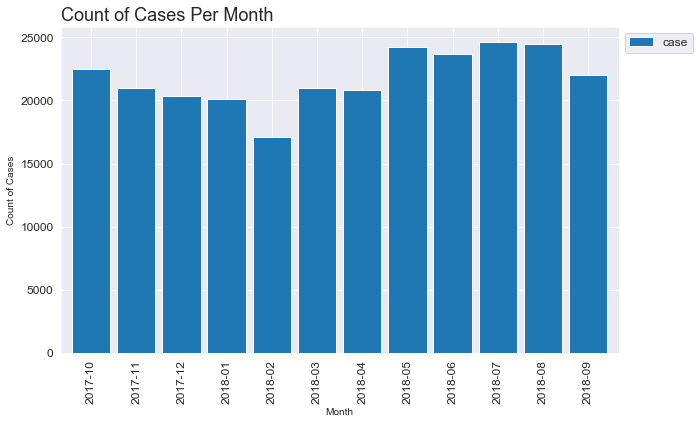

In [43]:
df.groupby('year_month').count().plot(y = 'case', 
                                      kind='bar',
                                      figsize=(10,6),
                                      width=0.85,
                                      fontsize=12,
                                      colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                               prop={'size': 12})

plt.xlabel('Month')
plt.ylabel('Count of Cases')
plt.title('Count of Cases Per Month', loc='left', fontsize=18)

Unsuprisingly there little obvious variation in the number of crimes committed per month other than an apparent drop-off in February. 

### Number of crimes occuring on each day

Text(0,1,'Count of Cases Per Day of Week [1 is a Tuesday]')

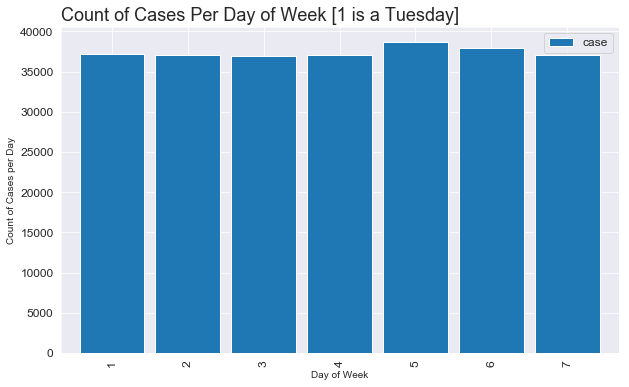

In [44]:
df.groupby('day').count().plot(y = 'case',
                               kind='bar',
                               figsize=(10,6),
                               width=0.85,
                               fontsize=12,
                               colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                        prop={'size': 12})

plt.xlabel('Day of Week')
plt.ylabel('Count of Cases per Day')
plt.title('Count of Cases Per Day of Week [1 is a Tuesday]', loc='left', fontsize=18)

There is a small increase in crime reported at the weekend, Saturday and Sunday, but nothing that couldbe considered significant.

### Number of crimes occuring in each hour

Text(0,1,'Count of Cases Per Hour]')

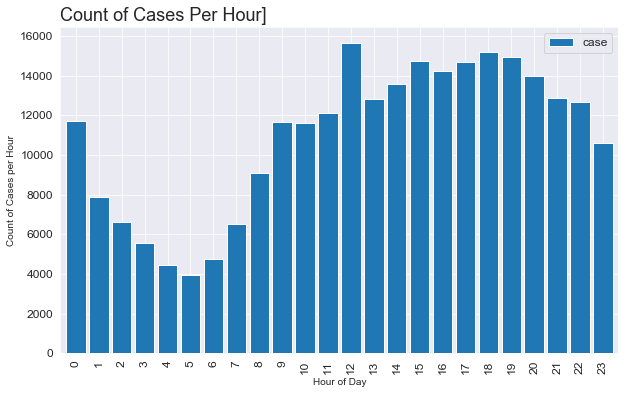

In [45]:
df.groupby('hour').count().plot(y = 'case',
                               kind='bar',
                               figsize=(10,6),
                               width=0.85,
                               fontsize=12,
                               colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                        prop={'size': 12})

plt.xlabel('Hour of Day')
plt.ylabel('Count of Cases per Hour')
plt.title('Count of Cases Per Hour]', loc='left', fontsize=18)

There is an expected fall-off in reported crime rates after midnight and before eight in the morning.

Now let's look at the Crime Categories.

In [46]:
# Number of unique Crime categories bases on the Primary Description
df.primary_description.nunique()

32

In [47]:
# What Crimes are the 3 most commonly occuring ones 
df[['primary_description', 'case']].groupby(
    ['primary_description'], as_index=False).count().sort_values('case', ascending=False).head(3)

,primary_description,case
30,THEFT,63629
2,BATTERY,49498
6,CRIMINAL DAMAGE,27980


In [48]:
# Create a list of the 10 most commonly occuring crimes
top_crimes = df[['primary_description', 'case']].groupby(
    ['primary_description']).count().sort_values('case', ascending=False)[:10].axes[0].tolist()

# Create a list of the 3 most commonly occuring crimes
top_three_crimes = df[['primary_description', 'case']].groupby(
    ['primary_description']).count().sort_values('case', ascending=False)[:3].axes[0].tolist()

# Create a list of the 2 most commonly occuring crimes
top_two_crimes = df[['primary_description', 'case']].groupby(
    ['primary_description']).count().sort_values('case', ascending=False)[:2].axes[0].tolist()

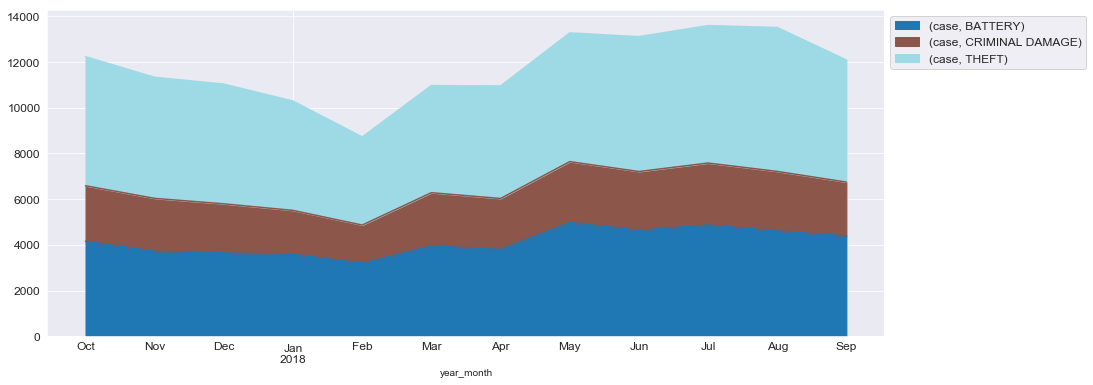

In [49]:
# Create a new data frame with just the top 10 crimes
df_top_crimes = df[df['primary_description'].isin(top_crimes)].copy()

# Create a new data frame with just the top 10 crimes
df_top3_crimes = df[df['primary_description'].isin(top_three_crimes)].copy()

df_top3_crimes[['case', 'primary_description', 'year_month']].pivot_table(
    index='year_month', 
    columns='primary_description', 
    fill_value=0, 
    aggfunc='count').plot(kind='area',
                          stacked=True,
                          figsize=(15, 6),
                               fontsize=12,
                               colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                        prop={'size': 12})

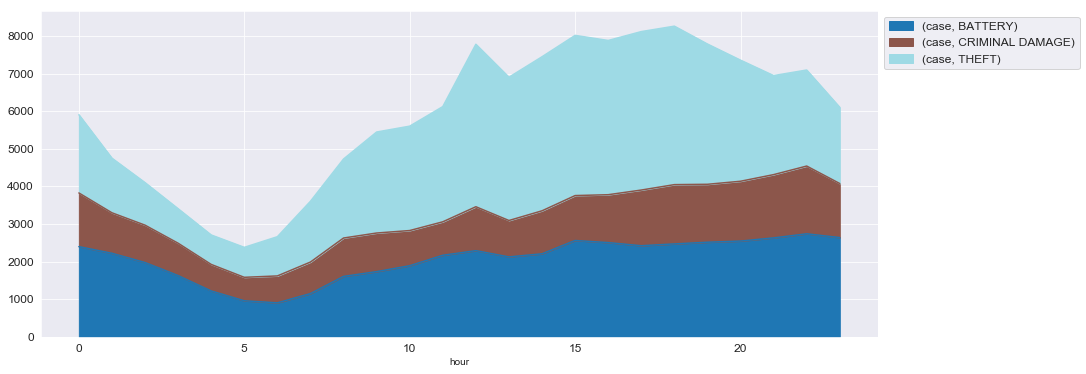

In [51]:
df_top3_crimes[['case', 'primary_description', 'hour']].pivot_table(
    index='hour', 
    columns='primary_description', 
    fill_value=0, 
    aggfunc='count').plot(kind='area',
                          stacked=True,
                          figsize=(15, 6),
                               fontsize=12,
                               colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                        prop={'size': 12})

### Visual Crimes on map of Chicago

In [84]:
df_top_crimes.dtypes

case                           object
date_of_occurrence     datetime64[ns]
block                          object
primary_description            object
ward                          float64
latitude                      float64
longitude                     float64
hour                            int64
day_name                       object
day                             int64
month_name                     object
month                           int64
year                            int64
year_month                     object
zip                            object
street                         object
dtype: object

### Create a folium map with a different colour per crime

Colour each of the top 10 crimes with a different and plot on a Folium map.

In [85]:
# Create a list of colours. 
# We have  list of the top 10 crimes from earlier
colors = [
    'red',
    'blue',
    'gray',
    'orange',
    'beige',
    'green',
    'purple',
    'pink',
    'cadetblue',
    'black'
]

# Create a dictionary of colours to map to the crimes
dict_colours = dict(zip(top_crimes, colors))

# Add the colours colums to the df_top_crimes DataFrame
df_top_crimes['colour'] = df_top_crimes.primary_description.map(dict_colours)

The entire `df_top_crimes` DataFrame contains too many point to disply effeciently using Folium. To combat this we will just use the data from August 2018.

In [86]:
df_top_crimes_august = df_top_crimes[df_top_crimes.month_name == 'August']

# Pickle the DataFrame to Separate the Folium Maps into a Separate Notepad
df_top_crimes_august.to_pickle('crimes_august.pkl')

```python
# Define Chicago's geolocation coordinates
chicago_latitude = 41.85  
chicago_longitude = -87.75

# Define the world map centered around Chicago with a higher zoom level
chicago_map = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=11)

# display world map
chicago_map

# Instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, col in zip(df_top_crimes_august.latitude, 
                         df_top_crimes_august.longitude, 
                         df_top_crimes_august.colour):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=1, # define how big you want the circle markers to be
            color=col,
            fill=True,
            fill_color=col,
            fill_opacity=0.6
        )
    )

# add incidents to map
chicago_map.add_child(incidents)```

![Markers image of Chicago](./capstone_images/markers.jpg)

```python
mc = MarkerCluster()

# Define the world map centered around Chicago with a higher zoom level
chicago_cluster = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=11)

# display world map
chicago_cluster

#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for row in df_top_crimes_august.itertuples():
    mc.add_child(folium.Marker(
        location=[row.latitude,  row.longitude],
                 popup=row.primary_description))
 
chicago_cluster.add_child(mc)
chicago_cluster```

![Clusters image of Chicago](./capstone_images/clusters.jpg)

```python
from folium import plugins
from folium.plugins import HeatMap

chicago_heatmat = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=11) 

# List comprehension to make out list of lists
heat_data = [[row['latitude'], 
              row['longitude']] for index, row in df_top_crimes_august.iterrows()]

# Plot it on the map
HeatMap(heat_data,
        min_opacity=0.5,
        max_zoom=18, 
        max_val=1.0, 
        radius=15,
        blur=20,
        gradient=None,
        overlay=True).add_to(chicago_heatmat)

# Display the map
chicago_heatmat```

![Heatmap image of Chicago](./capstone_images/heatmap.jpg)

In [107]:
df_top_crimes.dtypes

case                           object
date_of_occurrence     datetime64[ns]
block                          object
primary_description            object
ward                          float64
latitude                      float64
longitude                     float64
hour                            int64
day_name                       object
day                             int64
month_name                     object
month                           int64
year                            int64
year_month                     object
zip                            object
street                         object
colour                         object
dtype: object

# Data Preparation for Modelling

Before we start modelling we need to prepare the data frame to include only mumerical data and by removing unneeded columns.

Rather than removing colums from `df_top_crimes` a new `df_features` DataFrame will be created with just the required columns. This `df_features` DataFrame will then be processed to remove Categorical Data Types and replace them with One Hot encoding. Finally the Dependant Variables will be Normalised and Principal Component Analysis will be used to reduce the dimensionality of the DataFrame.

In [161]:
# Start by copying the Latitude and Longitude to the new DataFrame
df_features = df_top_crimes[['latitude', 'longitude']]

# Next and One Hot Encoding of the hour, day and month variables
df_features = df_features.join(pd.get_dummies(df_top_crimes.hour, prefix='hour'))
df_features = df_features.join(pd.get_dummies(df_top_crimes.day_name))
df_features = df_features.join(pd.get_dummies(df_top_crimes.month_name))

# Finally add the ward & crimes column, copied from the original Primary Description column
df_features['ward'] = df_top_crimes[['ward']]
df_features['crimes'] = df_top_crimes[['primary_description']]

In [155]:
df_features.head()

,latitude,longitude,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,April,August,December,February,January,July,June,March,May,November,October,September,ward,crimes
0,41.897895,-87.760744,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,37.0,NARCOTICS
1,41.798635,-87.604823,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5.0,CRIMINAL DAMAGE
2,41.780946,-87.621995,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,20.0,THEFT
3,41.965404,-87.736202,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,39.0,THEFT
5,41.891603,-87.745687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,28.0,MOTOR VEHICLE THEFT


There are a couple of further small changes to be made:
 - Create a smaller DataFrame of only the top three crimes
 - Create the X, dependant variables, DataFrames by dropping the Crimes column
 - Create the y, independant variable, 
 - Normailse the X Data

In [170]:
# Create a smaller DataFrame of only the top three crimes
df_features_3 = df_features[df_features['crimes'].isin(top_three_crimes)].copy()

# Create a smaller DataFrame of only the top two crimes
df_features_2 = df_features[df_features['crimes'].isin(top_two_crimes)].copy()

In [174]:
#  Create the X, dependant variables, DataFrames by dropping the Crimes column
X_10 = df_features.copy()
y_10 = X_10.crimes.values

X_10.drop('crimes', axis=1, inplace=True)
X_10 = preprocessing.StandardScaler().fit(X_10).transform(X_10)


X_3 = df_features_3.copy()
y_3 = X_3.crimes.values

X_3.drop('crimes', axis=1, inplace=True)
X_3 = preprocessing.StandardScaler().fit(X_3).transform(X_3)

X_2 = df_features_2.copy()
y_2 = X_2.crimes.values

X_2.drop('crimes', axis=1, inplace=True)
X_2 = preprocessing.StandardScaler().fit(X_2).transform(X_2)


In [114]:
# Set X = X_10
X = X_10
y = y_10

In [143]:
# Set X = X_3
X = X_3
y = y_3

In [175]:
# Set X = X_2
X = X_2
y = y_2

### K Nearest Neighbor(KNN)
Find the best k to build the model with the best accuracy.

Heighbours:  15   2018-09-27 18:30:05.079412
Heighbours:  15   2018-09-27 18:42:10.549026
Heighbours:  15   2018-09-27 18:54:24.891635
Heighbours:  15   2018-09-27 19:07:50.205988
Heighbours:  15   2018-09-27 19:20:38.551279
Heighbours:  15   2018-09-27 19:33:53.544815
Heighbours:  15   2018-09-27 19:50:07.531802


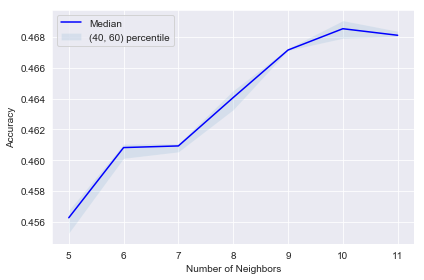

In [53]:
# Number of neighbours
neighs = range(5, 12)

# Store the scores
scores = np.zeros((len(neighs), 3))

for idx, neigh in enumerate(neighs):
    print('Heighbours: ', neigh, ' ', str(datetime.now()))
    model = KNeighborsClassifier(n_neighbors = neigh)
    scores[idx, : ] = cross_validate(model, n_splits = 5)

plt.plot(neighs, scores[ : , 1], 'b')
plt.fill_between(neighs, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

Depth:  10   2018-09-29 20:21:43.711835
Depth:  11   2018-09-29 20:21:52.729822
Depth:  12   2018-09-29 20:22:02.061035
Depth:  13   2018-09-29 20:22:11.946203
Depth:  14   2018-09-29 20:22:22.311324
Depth:  15   2018-09-29 20:22:33.211318


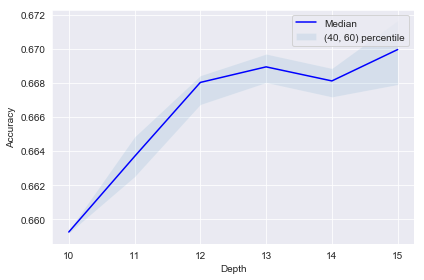

In [176]:
# Decision Tree
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier

depths = range(10, 16)
scores = np.zeros((len(depths), 3))
# scores = np.zeros((len(depths), 2))
for idx, depth in enumerate(depths):
    print('Depth: ', depth, ' ', str(datetime.now()))
    model = DecisionTreeClassifier(criterion = "entropy", max_depth = depth)
    scores[idx, : ] = cross_validate(model, n_splits = 10)

plt.plot(depths, scores[ : , 1], 'b')
plt.fill_between(depths, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.tight_layout()
plt.show()



C:  0.01   2018-09-29 19:55:35.850317
C:  0.03162277660168379   2018-09-29 19:55:54.529972
C:  0.1   2018-09-29 19:56:18.591961
C:  0.31622776601683794   2018-09-29 19:56:50.485827
C:  1.0   2018-09-29 19:57:08.953289
C:  3.1622776601683795   2018-09-29 19:57:32.267145


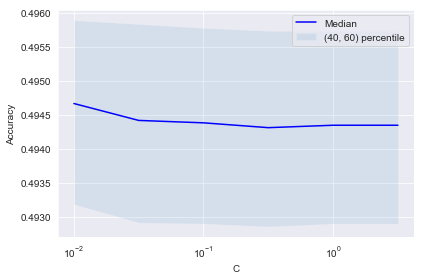

In [146]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

C = np.logspace(-2.0, 0.5, num = 6, endpoint = True)
scores = np.zeros((len(C), 3))
for idx, c in enumerate(C):
    print('C: ', c, ' ', str(datetime.now()))
    model = LogisticRegression(C = c, solver = 'liblinear')
    scores[idx, : ] = cross_validate(model, n_splits = 10)

plt.plot(C, scores[ : , 1], 'b')
plt.xscale('log')
plt.fill_between(C, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.tight_layout()
plt.show()

Alpha:  0.1   2018-09-29 19:58:32.874182
Alpha:  0.2   2018-09-29 19:58:38.732401
Alpha:  0.30000000000000004   2018-09-29 19:58:44.623051
Alpha:  0.4   2018-09-29 19:58:50.409530
Alpha:  0.5   2018-09-29 19:58:55.754630
Alpha:  0.6   2018-09-29 19:59:01.995696
Alpha:  0.7000000000000001   2018-09-29 19:59:07.390830
Alpha:  0.8   2018-09-29 19:59:12.751034
Alpha:  0.9   2018-09-29 19:59:18.619313
Alpha:  1.0   2018-09-29 19:59:24.275347


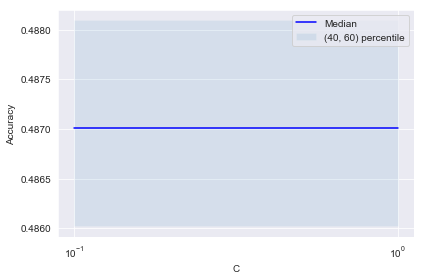

In [147]:
# Naive Bayes

alpha = np.linspace(0.1, 1, num=10)
scores = np.zeros((len(alpha), 3))
for idx, a in enumerate(alpha):
    print('Alpha: ', a, ' ', str(datetime.now()))
    model = BernoulliNB()
    scores[idx, : ] = cross_validate(model, n_splits = 10)

plt.plot(alpha, scores[ : , 1], 'b')
plt.xscale('log')
plt.fill_between(alpha, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.tight_layout()
plt.show()

Estimator:  12   2018-09-29 19:59:54.411928
Estimator:  13   2018-09-29 20:00:28.651094
Estimator:  14   2018-09-29 20:01:07.014314
Estimator:  15   2018-09-29 20:01:46.615577
Estimator:  16   2018-09-29 20:02:28.741745
Estimator:  17   2018-09-29 20:03:12.244684


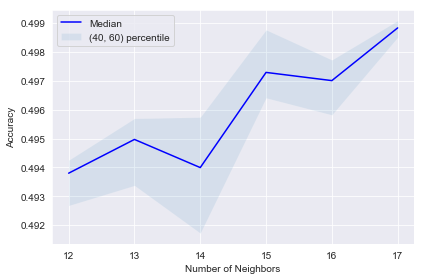

In [148]:
# Decision Forest using a Random Forest

est = range(12, 18)
scores = np.zeros((len(est), 3))
for idx, a in enumerate(est):
    print('Estimator: ', a, ' ', str(datetime.now()))
    model = RandomForestClassifier(n_estimators = a, max_features = 'sqrt')
    scores[idx, : ] = cross_validate(model, n_splits = 10)

plt.plot(est, scores[ : , 1], 'b')
plt.fill_between(est, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

In [ ]:
def cross_validate_02(model, n_splits = 10):

    Ks = 10
    mean_acc = np.zeros((Ks-1))
    std_acc = np.zeros((Ks-1))
    ConfustionMx = [];
    for n in range(1,Ks):

        #Train Model and Predict
        k_fold = KFold(n_splits = n_splits)
        for train, test in k_fold.split(X):
            neigh = KNeighborsClassifier(n_neighbors = n).fit(X[train], y[train])
            yhat=neigh.predict(X[test])
            mean_acc[n-1] = metrics.accuracy_score(y[test], yhat)
            std_acc[n-1]=np.std(yhat==y[test])/np.sqrt(yhat.shape[0])

    mean_acc
    
def cross_validate(model, n_splits = 10):
    
    k_fold = KFold(n_splits = n_splits)
    scores = [model.fit(X[train], y[train]).score(X[test], y[test]) for train, test in k_fold.split(X)]
    
    scores = np.percentile(scores, [40, 50, 60])
    return scores



In [52]:
import requests

page = requests.get("https://foursquare.com/explore?mode=url&near=Chicago%2C%20IL%2C%20United%20States&nearGeoId=72057594042815334&q=Top%20Picks")

from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')
top_venues = soup.find_all('div', class_='venueDetails')

In [53]:
top_venues[1]

<div class="venueDetails"><div class="venueName"><h2><a href="/v/millennium-park/42b75880f964a52090251fe3" target="_blank">Millennium Park</a></h2></div><div class="venueMeta"><div class="venueScore positive" style="background-color: #00B551;" title="9.7/10 - People like this place">9.7</div><div class="venueAddressData"><div class="venueAddress">201 E Randolph St (btwn Columbus Dr &amp; Michigan Ave), Chicago</div><div class="venueData"><span class="venueDataItem"><span class="categoryName">Park</span><span class="delim"> • </span></span></div></div></div></div>

In [71]:
venue_columns = ['id', 
                 'score', 
                 'category', 
                 'name', 
                 'address',
                 'postalcode',
                 'city',
                 'href', 
                 'latitude', 
                 'longitude']

df_top_venues = pd.DataFrame(columns=venue_columns)

for venue in top_venues:
    venue_name = venue.find(target="_blank").get_text()
    venue_score = venue.find(class_="venueScore positive").get_text()
    venue_cat = venue.find(class_="categoryName").get_text()
    venue_href = venue.find(class_="venueName").h2.a['href']
    venue_id = venue_href.split('/')[-1]

    if 'promotedTipId' in venue_id: 
        continue
        
    # Get the properly formatted address and the latitude and longitude
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        venue_id, 
        cfg['client_id'],
        cfg['client_secret'],
        cfg['version'])
    
    result = requests.get(url).json()
    
    # print(result['response']['venue']['location'])
    venue_address = result['response']['venue']['location']['address']
    venue_postalcode = result['response']['venue']['location']['postalCode']
    venue_city = result['response']['venue']['location']['city']
    venue_latitude = result['response']['venue']['location']['lat']
    venue_longitude = result['response']['venue']['location']['lng']
    
    df_top_venues = df_top_venues.append({'id': venue_id,
                                          'score': venue_score,
                                          'category': venue_cat,
                                          'name': venue_name,
                                          'address': venue_address,
                                          'postalcode': venue_postalcode,
                                          'city': venue_city,
                                          'href': venue_href,
                                          'latitude': venue_latitude,
                                          'longitude': venue_longitude}, ignore_index=True)


In [72]:
df_top_venues.shape

(30, 10)

In [73]:
df_top_venues.head()

,id,score,category,name,address,postalcode,city,href,latitude,longitude
0,42b75880f964a52090251fe3,9.7,Park,Millennium Park,201 E Randolph St,60601,Chicago,/v/millennium-park/42b75880f964a52090251fe3,41.882662,-87.623239
1,4b9511c7f964a520f38d34e3,9.6,Trail,Chicago Lakefront Trail,Lake Michigan Lakefront,60611,Chicago,/v/chicago-lakefront-trail/4b9511c7f964a520f38...,41.967053,-87.646909
2,49e9ef74f964a52011661fe3,9.6,Art Museum,The Art Institute of Chicago,111 S Michigan Ave,60603,Chicago,/v/the-art-institute-of-chicago/49e9ef74f964a5...,41.879665,-87.623630
3,4f2a0d0ae4b0837d0c4c2bc3,9.6,Deli / Bodega,Publican Quality Meats,825 W Fulton Market,60607,Chicago,/v/publican-quality-meats/4f2a0d0ae4b0837d0c4c...,41.886642,-87.648718
4,4aa05f40f964a520643f20e3,9.6,Theater,The Chicago Theatre,175 N State St,60601,Chicago,/v/the-chicago-theatre/4aa05f40f964a520643f20e3,41.885578,-87.627286


In [74]:
# Create a map with the top 10 locations

In [81]:
# Create a list of all the top venue latitude and longitude
top_venue_lats = df_top_venues['latitude'].values
top_venue_lngs = df_top_venues['longitude'].values

# Create a list of all the top venue names
top_venue_names = df_top_venues['name'].values

for ven_name, ven_lat, ven_long in zip(top_venue_names, top_venue_lats, top_venue_lngs):
    # print(ven_id, ven_name)
    
    # Configure additional Search parameters
    categoryId = '4d4b7105d754a06374d81259'
    radius = 500
    limit = 10
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
        cfg['client_id'],
        cfg['client_secret'],
        ven_lat,
        ven_long,
        cfg['version'],
        categoryId,
        radius,
        limit)
    
    results = requests.get(url).json()
    print('There are {} restaurants around the {} venue.'.format(
        len(results['response']['groups'][0]['items']),
        ven_name))




There are 10 restaurants around the Millennium Park venue.
There are 1 restaurants around the Chicago Lakefront Trail venue.
There are 10 restaurants around the The Art Institute of Chicago venue.
There are 10 restaurants around the Publican Quality Meats venue.
There are 10 restaurants around the The Chicago Theatre venue.
There are 10 restaurants around the Symphony Center (Chicago Symphony Orchestra) venue.
There are 10 restaurants around the Grant Park venue.
There are 10 restaurants around the Chicago Riverwalk venue.
There are 2 restaurants around the Garfield Park Conservatory venue.
There are 10 restaurants around the Joe's Seafood, Prime Steak & Stone Crab venue.
There are 10 restaurants around the Weber's Bakery venue.
There are 10 restaurants around the Binny's Beverage Depot venue.
There are 10 restaurants around the Nature Boardwalk venue.
There are 10 restaurants around the Music Box Theatre venue.
There are 10 restaurants around the Bari venue.
There are 10 restaurants a

In [ ]:
# Find the best place to eat at each of the top 10 locations

In [ ]:
# Create a map with the top 10 locations and the places to eat

In [ ]:
#For each of the locations add Crimes within 500 meters

In [ ]:
# Can we predict the crime